In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing


#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

# libraries for computation
import pandas as pd
import numpy as np

#library for train test split
from sklearn.model_selection import train_test_split,cross_val_score,KFold

#library for preprocessing
from sklearn.preprocessing import StandardScaler

#library for Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#Library for feature selection techniques
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectFromModel

#libraries for various ML models 
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#ensemble models
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor



#libraries for model performance evaluation
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score

#libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### Read Data from CSV

In [3]:
data = pd.read_csv('Arms-export.csv')

In [4]:
data.head()

,Country or Area,Year,Value,Value Footnotes
0,Afghanistan,1992,1000000.0,NaN
1,Albania,2011,0.0,2.0
2,Algeria,2016,0.0,2.0
3,Algeria,1980,6000000.0,NaN
4,Algeria,1968,6000000.0,NaN


#### lets drop extra column Value Footnotes

In [5]:
# Read data from csv and print the head
data = data.drop(columns=['Value Footnotes'])
data.head(5)

,Country or Area,Year,Value
0,Afghanistan,1992,1000000.0
1,Albania,2011,0.0
2,Algeria,2016,0.0
3,Algeria,1980,6000000.0
4,Algeria,1968,6000000.0


#### Get data insights

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2947 entries, 0 to 2946
Data columns (total 3 columns):
Country or Area    2947 non-null object
Year               2947 non-null object
Value              2945 non-null float64
dtypes: float64(1), object(2)
memory usage: 69.1+ KB


#### it seems column Value has some missing values or NaN 

In [7]:
vals = data['Value']

In [8]:
d = data[ vals.isna() ]
d

,Country or Area,Year,Value
2945,footnoteSeqID,Footnote,NaN
2946,2,Value of deliveries is less than 0.5 million TIV,NaN


##### lets drop this entries

In [10]:
data  = data [0:2945] 

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2945 entries, 0 to 2944
Data columns (total 3 columns):
Country or Area    2945 non-null object
Year               2945 non-null object
Value              2945 non-null float64
dtypes: float64(1), object(2)
memory usage: 69.1+ KB


### Lets normalize data

In [12]:
# Normalize the value column and drop old column

# Create x, where x the 'Value' column's values as floats
x = data[['Value']].values.astype(float)

# Create a minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_normalized = pd.DataFrame(x_scaled)
df_normalized['normalized'] = pd.DataFrame(x_scaled)
df_normalized.drop(columns=0,inplace=True)

data_new = pd.concat([data,df_normalized ], axis=1)
data_new.drop(columns='Value',inplace=True)

In [13]:
# Check new dataframe with normalized value
data_new.head()

,Country or Area,Year,normalized
0,Afghanistan,1992,0.000038
1,Albania,2011,0.000000
2,Algeria,2016,0.000000
3,Algeria,1980,0.000227
4,Algeria,1968,0.000227


#### Using tsfresh to extract features from data

In [14]:
# Use TSFresh library to extract features from data 
from tsfresh import extract_features
extracted_features = extract_features(data_new, column_id="Country or Area", column_sort="Year")

Feature Extraction: 100%|██████████| 10/10 [00:11<00:00,  1.01it/s]


In [15]:
#Check extracted features
extracted_features.head()

variable,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,normalized__time_reversal_asymmetry_statistic__lag_1,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.435999e-09,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0
Albania,0.000000e+00,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.0
Algeria,1.033919e-07,0.000227,-0.625000,-0.625000,0.140625,NaN,NaN,NaN,NaN,NaN,...,-1.175398e-11,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,1.148799e-08,0.0
Angola,1.105719e-07,0.000644,-0.195843,0.035971,0.178694,NaN,NaN,NaN,NaN,NaN,...,8.706652e-13,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,1.247524e-08,0.0
Arab World,8.854226e-05,0.018379,-0.256093,-0.155176,0.149056,0.002008,1.0,0.006215,0.0,NaN,...,1.042309e-08,9.121796e-10,1.729617e-08,0.0,1.0,0.0,0.0,0.0,4.657450e-06,0.0


In [16]:
#Check shape of new data with extracted features
extracted_features.shape

(162, 794)

In [17]:
#Check if any columns contains Nan values (null values)
list_cols_with_nan = extracted_features.columns[extracted_features.isna().any()].tolist()
len(list_cols_with_nan)

568

In [19]:
# it seems 568 columns out of 794 have some null values

In [20]:
#lets replace nan value with 0.0
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute
data_after_impute = impute(extracted_features)

 'normalized__fft_coefficient__coeff_30__attr_"angle"'
 'normalized__fft_coefficient__coeff_30__attr_"imag"'
 'normalized__fft_coefficient__coeff_30__attr_"real"'
 'normalized__fft_coefficient__coeff_31__attr_"abs"'
 'normalized__fft_coefficient__coeff_31__attr_"angle"'
 'normalized__fft_coefficient__coeff_31__attr_"imag"'
 'normalized__fft_coefficient__coeff_31__attr_"real"'
 'normalized__fft_coefficient__coeff_32__attr_"abs"'
 'normalized__fft_coefficient__coeff_32__attr_"angle"'
 'normalized__fft_coefficient__coeff_32__attr_"imag"'
 'normalized__fft_coefficient__coeff_32__attr_"real"'
 'normalized__fft_coefficient__coeff_33__attr_"abs"'
 'normalized__fft_coefficient__coeff_33__attr_"angle"'
 'normalized__fft_coefficient__coeff_33__attr_"imag"'
 'normalized__fft_coefficient__coeff_33__attr_"real"'
 'normalized__fft_coefficient__coeff_34__attr_"abs"'
 'normalized__fft_coefficient__coeff_34__attr_"angle"'
 'normalized__fft_coefficient__coeff_34__attr_"imag"'
 'normalized__fft_coefficie

In [21]:
#lets check if any column has any nan value
list_cols_with_nan_after_impute = data_after_impute.columns[data_after_impute.isna().any()].tolist()
len(list_cols_with_nan_after_impute)

0

In [22]:
#we dont have any nan values 
# lets reset the index
data_after_impute = data_after_impute.reset_index()

In [23]:
# #Creating new Csv
# data_after_impute.to_csv('new.csv')

In [24]:
# # read from new csv file 
# df = pd.read_csv('new.csv')
# df.head()

In [25]:
# we need to give labels to countries 
data_countries = pd.read_excel('Developing countries.xlsx')

developed_countries = data_countries [data_countries['Value'] == 0]
developing_countries = data_countries [data_countries['Value'] == 1] 

list_developed_countries = developed_countries['Countries']
list_developing_countries = developing_countries['Countries']

list_developed_countries = list(list_developed_countries)
list_developing_countries = list(list_developing_countries)

data_after_impute['label'] = -1

for i,da in data_after_impute.iterrows():
    if da['id'] in list_developed_countries:
        val = 1
        data_after_impute.at[i,'label'] = val
    elif da['id'] in list_developing_countries:
        val = 0
        data_after_impute.at[i,'label'] = val

In [26]:
# check new df with added column as label 
data_after_impute.head()

variable,id,normalized__abs_energy,normalized__absolute_sum_of_changes,"normalized__agg_autocorrelation__f_agg_""mean""","normalized__agg_autocorrelation__f_agg_""median""","normalized__agg_autocorrelation__f_agg_""var""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","normalized__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""",...,normalized__time_reversal_asymmetry_statistic__lag_2,normalized__time_reversal_asymmetry_statistic__lag_3,normalized__value_count__value_-inf,normalized__value_count__value_0,normalized__value_count__value_1,normalized__value_count__value_inf,normalized__value_count__value_nan,normalized__variance,normalized__variance_larger_than_standard_deviation,label
0,Afghanistan,1.435999e-09,0.000000,0.000000,0.000000,0.000000,0.005316,0.218787,0.000430,0.000687,...,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,-1
1,Albania,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.005316,0.218787,0.000430,0.000687,...,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,0.000000e+00,0.0,-1
2,Algeria,1.033919e-07,0.000227,-0.625000,-0.625000,0.140625,0.005316,0.218787,0.000430,0.000687,...,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,1.148799e-08,0.0,0
3,Angola,1.105719e-07,0.000644,-0.195843,0.035971,0.178694,0.005316,0.218787,0.000430,0.000687,...,0.000000e+00,0.000000e+00,0.0,1.0,0.0,0.0,0.0,1.247524e-08,0.0,0
4,Arab World,8.854226e-05,0.018379,-0.256093,-0.155176,0.149056,0.002008,1.000000,0.006215,0.000000,...,9.121796e-10,1.729617e-08,0.0,1.0,0.0,0.0,0.0,4.657450e-06,0.0,-1


In [27]:
#Split data into X(features),y 
y = data_after_impute['label']
X = data_after_impute.drop(columns=['id','label'])

In [28]:
y.value_counts()

-1    68
 0    59
 1    35
Name: label, dtype: int64

In [29]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [31]:
y_test.value_counts()

-1    29
 0    21
 1    15
Name: label, dtype: int64

In [32]:
y_train.value_counts()

-1    39
 0    38
 1    20
Name: label, dtype: int64

#### Lets try different classifiers on the data

##### KNN

In [33]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
dsf = classification_report(y_test,pred)
acc = accuracy_score(y_test,pred) 
print(dsf)
print('Accuracy is: ',acc)

             precision    recall  f1-score   support

         -1       0.43      0.45      0.44        29
          0       0.26      0.43      0.32        21
          1       0.00      0.00      0.00        15

avg / total       0.28      0.34      0.30        65

Accuracy is:  0.3384615384615385


###### KNN with k ranging from 1 to 15

[0.4153846153846154, 0.4, 0.5076923076923077, 0.46153846153846156, 0.4153846153846154, 0.38461538461538464, 0.38461538461538464, 0.36923076923076925, 0.3230769230769231, 0.3384615384615385, 0.4, 0.3076923076923077, 0.35384615384615387, 0.46153846153846156, 0.35384615384615387]


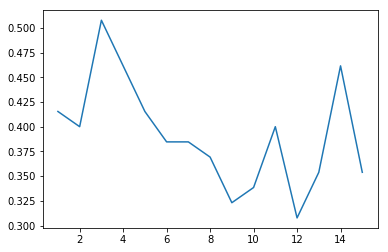

In [34]:
#KNN for different k values
kVals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test,pred))
    
plt.plot(kVals,scores)    
print(scores)  

#### Random Forest Classifier

In [35]:
rf_classifier = RandomForestClassifier(n_estimators=10, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.5395177481662106
Accuracy Score:  0.5384615384615384


#### Fine tuninng Random Forest for different number of estimators

5-------0.4784073990525603
10-------0.5395177481662106
15-------0.5132881884849431
20-------0.537701525669244
30-------0.5870737532480894
35-------0.6002618932430254
40-------0.5723007151578581
45-------0.558032575391066
50-------0.5714137614407157
100-------0.5864763014763014
200-------0.5515517765592728
300-------0.4965822427266736


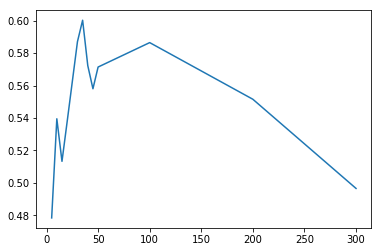

In [36]:
#Ensemble Random Forest Classifier Fine Tunning
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    rf_classifier = RandomForestClassifier(n_estimators=e, random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
for i in range (0,len(estimators)):
    print(str(estimators[i]) + "-------" + str(f1_scores[i]))

#### Lets fine tune for number of features with best number of estimator from above analysis

In [37]:
rf_classifier = RandomForestClassifier(n_estimators=35, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.6002618932430254
Accuracy Score:  0.6


[0.581320338786402, 0.5133333333333333, 0.5317743962027084, 0.606107638991736, 0.6050772645316033, 0.5418331668331668, 0.5839360158107649, 0.5365425971877584, 0.5080891330891331, 0.5363206508633794, 0.5375485625485625]


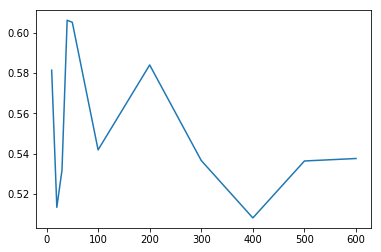

In [38]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    rf_classifier = RandomForestClassifier(max_features = e ,n_estimators=30,random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores) 
print(f1_scores)

#### Logistic regression model

In [39]:
#Logistic Regression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
pred = logmodel.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.4172408310667704
Accuracy Score:  0.49230769230769234


#### Extra tree classifier

In [40]:
#ExtraTreeClassifier
model = ExtraTreesClassifier(n_estimators=5,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.41518457901436623
Accuracy Score:  0.4153846153846154


[0.41518457901436623, 0.4783577533577534, 0.5427092404450895, 0.5146735617323852, 0.528, 0.5437621202327084, 0.49421982192380676, 0.4964632006648814, 0.528, 0.5736079047003417, 0.5224314765694076, 0.5257357137034319]


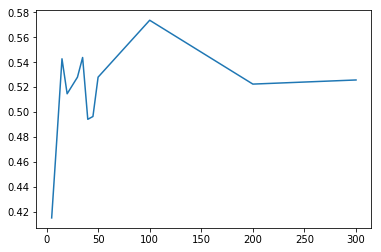

In [41]:
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    model = ExtraTreesClassifier(n_estimators=e,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
print(f1_scores)

In [43]:
model = ExtraTreesClassifier(n_estimators=100,random_state=42)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("F1 Score: ", metrics.f1_score(y_test,pred, average='weighted'))
print("Accuracy Score: ", accuracy_score(y_test,pred))

F1 Score:  0.5736079047003417
Accuracy Score:  0.5692307692307692


#### fine tune for max_features

[0.5196331969916876, 0.6044879490257641, 0.5436081242532855, 0.5270440434896668, 0.49602997923735254, 0.4707721780135573, 0.5423202041939843, 0.5713369963369963, 0.529128677773839, 0.49421982192380676, 0.5130790777849602]


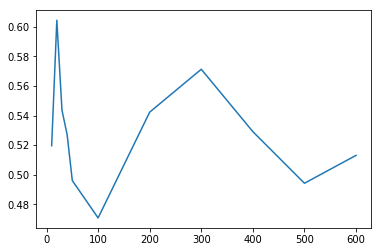

In [44]:
no_of_features = [10,20,30,40,50,100,200,300,400,500,600]
f1_scores = []
for e in no_of_features:
    model = ExtraTreesClassifier(max_features=e,n_estimators=20,random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(no_of_features,f1_scores) 
print(f1_scores)

#### Recursive Feature Elimination 

In [45]:
# The "accuracy" scoring is proportional to the number of correct classifications
clf_rf_4 = RandomForestClassifier() 
rfecv = RFECV(estimator=clf_rf_4, step=1, cv=5,scoring='accuracy')   #5-fold cross-validation
rfecv = rfecv.fit(X_train, y_train)

print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 626
Best features : Index(['normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.0',
       'normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.2',
       'normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.4',
       'normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.6',
       'normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.6__ql_0.8',
       'normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.0',
       'normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.2',
       'normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.4',
       'normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.6',
       'normalized__change_quantiles__f_agg_"mean"__isabs_True__qh_0.8__ql_0.8',
       ...
       'normalized__symmetry_looking__r_0.9500000000000001',
       'normalized__time_reversal_asymmetry_statistic__lag_1',
      

In [46]:
cols = X_train.columns[rfecv.support_]

In [47]:
X = X[cols]

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=42)

In [49]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
dsf = classification_report(y_test,pred)
acc = accuracy_score(y_test,pred) 
print(dsf)
print('Accuracy is: ',acc)

             precision    recall  f1-score   support

         -1       0.48      0.55      0.52        29
          0       0.31      0.48      0.38        21
          1       0.00      0.00      0.00        15

avg / total       0.32      0.40      0.35        65

Accuracy is:  0.4


[0.4461538461538462, 0.4307692307692308, 0.5538461538461539, 0.5230769230769231, 0.4461538461538462, 0.4461538461538462, 0.46153846153846156, 0.4461538461538462, 0.4, 0.4, 0.47692307692307695, 0.36923076923076925, 0.4, 0.5076923076923077, 0.4461538461538462]


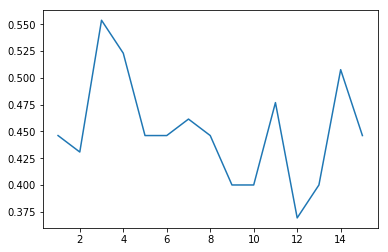

In [50]:
#KNN for different k values
kVals = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
scores = []

for k in kVals:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test,pred))
    
plt.plot(kVals,scores)    
print(scores) 

[0.40163507989594943, 0.4497655535953408, 0.5386015848231549, 0.4881522335107241, 0.5300565417488494, 0.4979087106746681, 0.4968893387314439, 0.48498168498168504, 0.4979087106746681, 0.48637024913620663, 0.4870612428507165, 0.516710875331565]


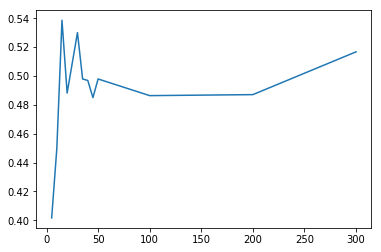

In [51]:
#Ensemble Random Forest Classifier Fine Tunning
estimators = [5,10,15,20,30,35,40,45,50,100,200,300]
f1_scores = []
for e in estimators:
    rf_classifier = RandomForestClassifier(n_estimators=e, random_state = 42)
    rf_classifier.fit(X_train,y_train)
    pred = rf_classifier.predict(X_test)
    f1_scores.append(f1_score(y_test,pred,average='weighted'))
    
plt.plot(estimators,f1_scores) 
print(f1_scores)

In [52]:
rf_classifier = RandomForestClassifier(n_estimators=30, random_state = 42)
rf_classifier.fit(X_train,y_train)
pred = rf_classifier.predict(X_test)
dsf = classification_report(y_test,pred)
acc = accuracy_score(y_test,pred) 
print(dsf)
print('Accuracy is: ',acc)

             precision    recall  f1-score   support

         -1       0.67      0.48      0.56        29
          0       0.48      0.76      0.59        21
          1       0.45      0.33      0.38        15

avg / total       0.56      0.54      0.53        65

Accuracy is:  0.5384615384615384
